### 1. B-Spline 기저 함수

In [1]:
import torch

def B_batch(x, grid, k=0, device='cpu'):
    '''
    주어진 점 x에서 B-스플라인 기저 함수를 평가합니다.

    Args:
    -----
        x : torch.Tensor
            입력 텐서로, 크기는 (batch_size, in_dim).
        grid : torch.Tensor
            노드 벡터로, 크기는 (in_dim, num_knots).
        k : int
            B-스플라인의 차수.
        device : str
            연산을 수행할 디바이스.

    Returns:
    --------
        value : torch.Tensor
            평가된 B-스플라인 기저 함수로, 크기는 (batch_size, in_dim, num_basis).
    '''
    x = x.unsqueeze(dim=2)
    grid = grid.unsqueeze(dim=0)

    if k == 0:
        value = ((x >= grid[:, :, :-1]) & (x < grid[:, :, 1:])).float()
    else:
        B_km1 = B_batch(x[:, :, 0], grid[0], k=k - 1).to(device)
        denom1 = grid[:, :, k:-1] - grid[:, :, :-(k + 1)]
        denom2 = grid[:, :, k + 1:] - grid[:, :, 1:(-k)]
        denom1[denom1 == 0] = 1e-8
        denom2[denom2 == 0] = 1e-8
        term1 = ((x - grid[:, :, :-(k + 1)]) / denom1) * B_km1[:, :, :-1]
        term2 = ((grid[:, :, k + 1:] - x) / denom2) * B_km1[:, :, 1:]
        value = term1 + term2

    value = torch.nan_to_num(value)
    return value

In [2]:
# 입력 데이터
x = torch.linspace(-1, 1, steps=5).unsqueeze(1)  # (batch_size, in_dim)

# 노드 벡터 생성
grid = torch.linspace(-1, 1, steps=5).unsqueeze(0)  # (in_dim, num_knots)

# 차수 설정
k = 2

# 함수 호출
B_values = B_batch(x, grid, k=k)

print("B-스플라인 기저 함수 값:")
print(B_values)

B-스플라인 기저 함수 값:
tensor([[[0.0000, 0.0000]],

        [[0.5000, 0.0000]],

        [[0.5000, 0.5000]],

        [[0.0000, 0.5000]],

        [[0.0000, 0.0000]]])


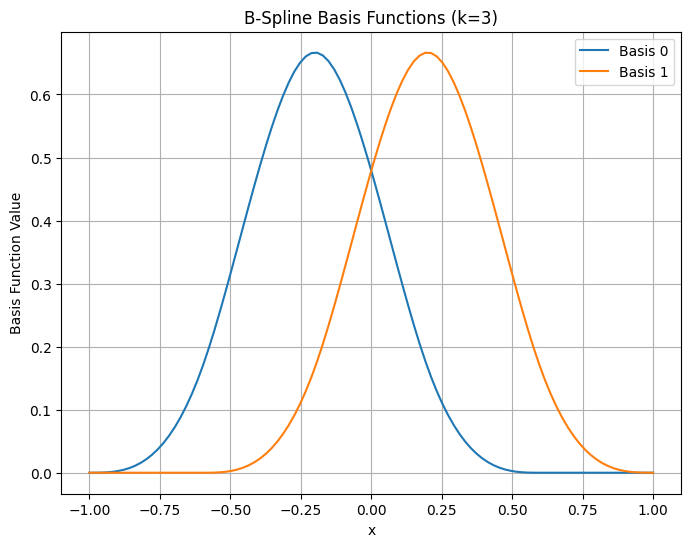

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 입력 데이터 생성
x = torch.linspace(-1, 1, steps=100).unsqueeze(1)  # (batch_size=100, in_dim=1)

# 노드 벡터 생성
num_knots = 6
grid = torch.linspace(-1, 1, steps=num_knots).unsqueeze(0)  # (in_dim=1, num_knots=6)

# 차수 설정
k = 3  # 3차 스플라인

# B-스플라인 기저 함수 평가
B_values = B_batch(x, grid, k=k, device='cpu')  # (batch_size=100, in_dim=1, num_basis=3)

# 시각화
plt.figure(figsize=(8, 6))
for i in range(B_values.shape[2]):
    plt.plot(x.squeeze().numpy(), B_values[:, 0, i].detach().numpy(), label=f'Basis {i}')
plt.title(f'B-Spline Basis Functions ({k=})')
plt.xlabel('x')
plt.ylabel('Basis Function Value')
plt.legend()
plt.grid(True)
plt.show()

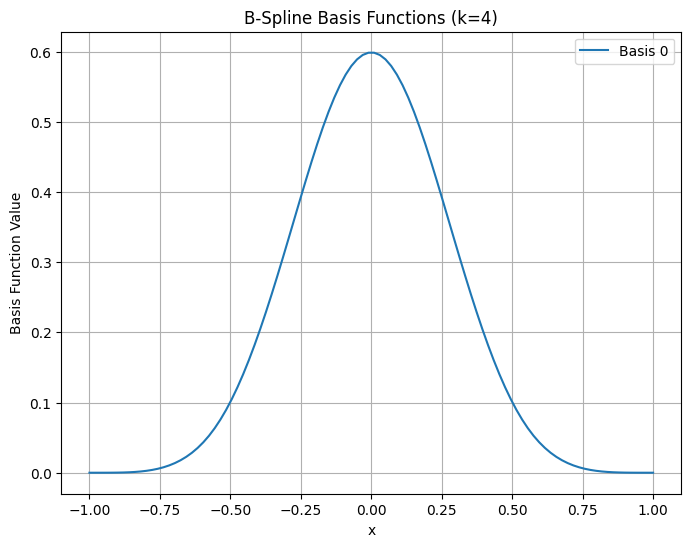

In [4]:
# 노드 벡터 생성
num_knots = 6
grid = torch.linspace(-1, 1, steps=num_knots).unsqueeze(0)  # (in_dim=1, num_knots=6)

# 차수 설정
k = 4  

# B-스플라인 기저 함수 평가
B_values = B_batch(x, grid, k=k, device='cpu')  # (batch_size=100, in_dim=1, num_basis=3)

# 시각화
plt.figure(figsize=(8, 6))
for i in range(B_values.shape[2]):
    plt.plot(x.squeeze().numpy(), B_values[:, 0, i].detach().numpy(), label=f'Basis {i}')
plt.title(f'B-Spline Basis Functions ({k=})')
plt.xlabel('x')
plt.ylabel('Basis Function Value')
plt.legend()
plt.grid(True)
plt.show()

### 2. 계수와 곡선 간의 변환 함수

In [5]:
def coef2curve(x_eval, grid, coef, k, device='cpu'):
    '''
    주어진 계수를 사용하여 x_eval에서 B-스플라인 곡선을 평가합니다.

    Args:
    -----
        x_eval : torch.Tensor
            크기 (batch_size, in_dim)의 입력 텐서.
        grid : torch.Tensor
            크기 (in_dim, num_knots)의 노드 벡터.
        coef : torch.Tensor
            크기 (in_dim, out_dim, num_basis)의 B-스플라인 계수.
        k : int
            B-스플라인의 차수.
        device : str
            연산을 수행할 디바이스.

    Returns:
    --------
        y_eval : torch.Tensor
            크기 (batch_size, in_dim, out_dim)의 평가된 스플라인 곡선.
    '''
    b_splines = B_batch(x_eval, grid, k=k, device=device)
    y_eval = torch.einsum('ijk,jlk->ijl', b_splines, coef.to(device))
    return y_eval

def curve2coef(x_eval, y_eval, grid, k, lamb=1e-8):
    '''
    주어진 곡선 평가값으로부터 B-스플라인 계수를 계산합니다.

    Args:
    -----
        x_eval : torch.Tensor
            크기 (batch_size, in_dim)의 입력 텐서.
        y_eval : torch.Tensor
            크기 (batch_size, in_dim, out_dim)의 평가된 곡선 값.
        grid : torch.Tensor
            크기 (in_dim, num_knots)의 노드 벡터.
        k : int
            B-스플라인의 차수.
        lamb : float
            정규화 파라미터.

    Returns:
    --------
        coef : torch.Tensor
            크기 (in_dim, out_dim, num_basis)의 계산된 B-스플라인 계수.
    '''
    batch = x_eval.shape[0]
    in_dim = x_eval.shape[1]
    out_dim = y_eval.shape[2]
    n_coef = grid.shape[1] - k - 1

    mat = B_batch(x_eval, grid, k).permute(1, 0, 2)
    mat = mat.unsqueeze(1).expand(-1, out_dim, -1, -1)
    y_eval = y_eval.permute(1, 2, 0).unsqueeze(3)

    XtX = torch.einsum('ijmn,ijnp->ijmp', mat.transpose(2, 3), mat)
    Xty = torch.einsum('ijmn,ijnp->ijmp', mat.transpose(2, 3), y_eval)
    n1, n2, n = XtX.shape[0], XtX.shape[1], XtX.shape[2]
    identity = torch.eye(n, n, device=mat.device).unsqueeze(0).unsqueeze(0).expand(n1, n2, -1, -1)
    A = XtX + lamb * identity
    B = Xty
    coef = torch.linalg.solve(A, B).squeeze(-1)
    return coef

In [6]:
# 계수와 곡선 간의 변환 확인

# 입력 데이터 생성
x_eval = torch.linspace(-1, 1, steps=10).unsqueeze(1)  # (batch_size, in_dim)
y_true = torch.sin(x_eval)  # 실제 곡선 값

# 노드 벡터 생성
grid = torch.linspace(-1, 1, steps=5).unsqueeze(0)  # (in_dim, num_knots)
k = 3  # 차수

# 곡선으로부터 계수 계산
coef = curve2coef(x_eval, y_true.unsqueeze(2), grid, k)

# 계수를 사용하여 곡선 복원
y_pred = coef2curve(x_eval, grid, coef, k)

print("원래 곡선 값:")
print(y_true.squeeze())
print("복원된 곡선 값:")
print(y_pred.squeeze())

원래 곡선 값:
tensor([-0.8415, -0.7017, -0.5274, -0.3272, -0.1109,  0.1109,  0.3272,  0.5274,
         0.7017,  0.8415])
복원된 곡선 값:
tensor([0.0000e+00, 2.4021e-10, 1.9217e-09, 6.0803e-09, 1.0224e-08, 1.0224e-08,
        6.0803e-09, 1.9217e-09, 2.4021e-10, 0.0000e+00])


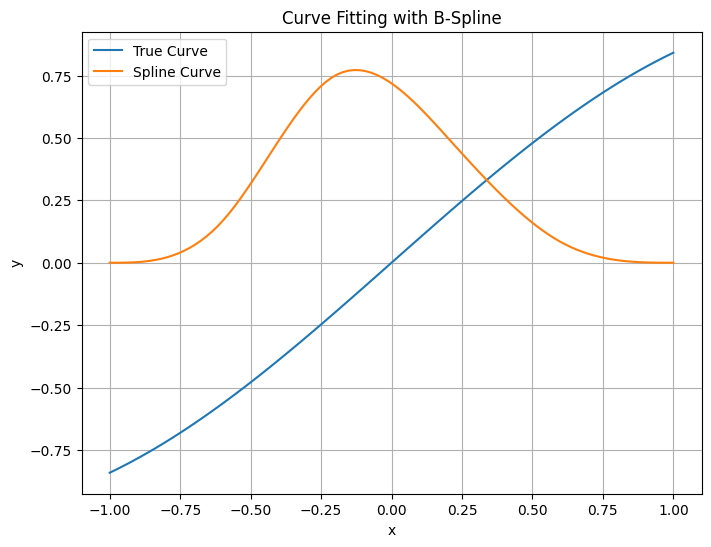

In [7]:
# 입력 데이터 생성
x_eval = torch.linspace(-1, 1, steps=100).unsqueeze(1)  # (batch_size=100, in_dim=1)
y_true = torch.sin(x_eval)  # 실제 곡선 값 (batch_size=100, in_dim=1)

# 노드 벡터 생성
num_knots = 6
grid = torch.linspace(-1, 1, steps=num_knots).unsqueeze(0)  # (in_dim=1, num_knots=6)
k = 3  # 차수

# 임의의 계수 생성 (in_dim=1, out_dim=1, num_basis=2)
# num_basis = num_knots - k -1 = 6 -3 -1 =2
coef = torch.tensor([[[1.0, 0.5]]])  # (1, 1, 2)

# 곡선 생성
y_pred = coef2curve(x_eval, grid, coef, k=k, device='cpu')  # (batch_size=100, in_dim=1, out_dim=1)
y_pred = y_pred.squeeze(2)  # (batch_size=100, in_dim=1)

# 시각화
plt.figure(figsize=(8, 6))
plt.plot(x_eval.numpy(), y_true.numpy(), label='True Curve')
plt.plot(x_eval.numpy(), y_pred.detach().numpy(), label='Spline Curve')
plt.title('Curve Fitting with B-Spline')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


### 3. 그리드 확장

In [8]:
def extend_grid(grid, k_extend=0):
    '''
    스플라인의 경계 조건을 처리하기 위해 그리드를 확장합니다.

    Args:
    -----
        grid : torch.Tensor
            크기 (in_dim, num_knots)의 원래 노드 벡터.
        k_extend : int
            각 경계에서 확장할 노드의 수.

    Returns:
    --------
        extended_grid : torch.Tensor
            확장된 노드 벡터.
    '''
    h = (grid[:, -1:] - grid[:, :1]) / (grid.shape[1] - 1)
    for _ in range(k_extend):
        grid = torch.cat([grid[:, :1] - h, grid, grid[:, -1:] + h], dim=1)
    return grid

In [9]:
# 그리드 확장 테스트

# 원래 그리드 생성
grid = torch.linspace(0, 1, steps=5).unsqueeze(0)  # (in_dim, num_knots)

# 그리드 확장
k_extend = 2  # 확장할 노드 수
extended_grid = extend_grid(grid, k_extend=k_extend)

print("원래 그리드:")
print(grid)
print("확장된 그리드:")
print(extended_grid)


원래 그리드:
tensor([[0.0000, 0.2500, 0.5000, 0.7500, 1.0000]])
확장된 그리드:
tensor([[-0.5000, -0.2500,  0.0000,  0.2500,  0.5000,  0.7500,  1.0000,  1.2500,
          1.5000]])


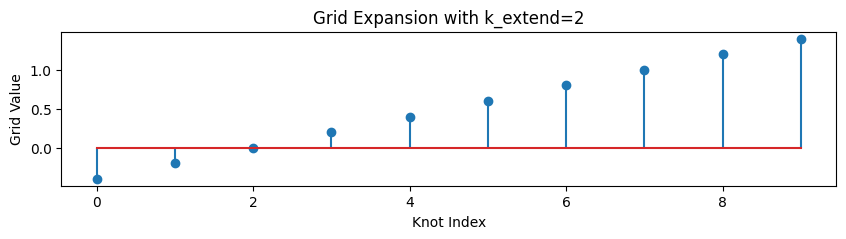

In [10]:
# 그리드 확장 예제
import torch
import matplotlib.pyplot as plt

# 원래 그리드 생성
num_knots = 6
grid = torch.linspace(0, 1, steps=num_knots).unsqueeze(0)  # (in_dim=1, num_knots=6)

# 그리드 확장
k_extend = 2  # 확장할 노드 수
extended_grid = extend_grid(grid, k_extend=k_extend)  # (1, 6 + 2*2 =10)

# 시각화
plt.figure(figsize=(10, 2))
plt.stem(range(extended_grid.shape[1]), extended_grid.squeeze().numpy())
plt.title(f'Grid Expansion with k_extend={k_extend}')
plt.xlabel('Knot Index')
plt.ylabel('Grid Value')
plt.show()


### 4. KAN Layer

In [11]:
import torch
import torch.nn as nn
import numpy as np

class KANLayer(nn.Module):
    """
    KANLayer 클래스

    Attributes:
    -----------
        in_dim : int
            입력 차원.
        out_dim : int
            출력 차원.
        num : int
            그리드 구간 수.
        k : int
            B-스플라인의 차수.
        noise_scale : float
            초기화 시 노이즈의 스케일.
        coef : torch.Tensor
            B-스플라인 기저 함수의 계수.
        scale_base_mu : float
            기본 함수 스케일링 계수의 평균.
        scale_base_sigma : float
            기본 함수 스케일링 계수의 표준편차.
        scale_sp : float
            스플라인 함수의 스케일링 계수.
        base_fun : callable
            기본 함수 b(x).
        mask : torch.Tensor
            활성/비활성 활성화를 나타내는 마스크.
        grid_eps : float
            그리드 적응을 제어하는 파라미터.
        device : str
            연산을 수행할 디바이스.
    """

    def __init__(self, in_dim=3, out_dim=2, num=5, k=3, noise_scale=0.1,
                 scale_base_mu=0.0, scale_base_sigma=1.0, scale_sp=1.0,
                 base_fun=torch.nn.SiLU(), grid_eps=0.02, grid_range=[-1, 1],
                 sp_trainable=True, sb_trainable=True, device='cpu', sparse_init=False):
        super(KANLayer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num = num
        self.k = k
        self.grid_eps = grid_eps
        self.device = device

        # 그리드 초기화
        grid = torch.linspace(grid_range[0], grid_range[1], steps=num + 1).unsqueeze(0).repeat(in_dim, 1)
        grid = extend_grid(grid, k_extend=k)  # (in_dim, num + 1 + 2k)
        self.grid = nn.Parameter(grid, requires_grad=False)

        # 계수 초기화
        num_knots = num + 1 + 2 * k  # 그리드 점의 총 수
        num_basis = num + k  # B-스플라인 기저 함수의 수

        # x_eval의 차원: (num + 1, in_dim)
        x_eval = self.grid[:, k:-k].t()  # 내부 그리드 점들

        # noises의 차원을 x_eval과 맞춤: (num + 1, in_dim, out_dim)
        noises = (torch.rand(num + 1, in_dim, out_dim) - 0.5) * noise_scale / num

        # coef 계산
        self.coef = nn.Parameter(curve2coef(x_eval, noises, self.grid, k), requires_grad=True)

        # 나머지 초기화 코드는 그대로 유지
        self.scale_base = nn.Parameter(
            scale_base_mu / np.sqrt(in_dim) +
            scale_base_sigma * (torch.rand(in_dim, out_dim) * 2 - 1) / np.sqrt(in_dim),
            requires_grad=sb_trainable
        )
        self.scale_sp = nn.Parameter(torch.ones(in_dim, out_dim) * scale_sp, requires_grad=sp_trainable)

        self.base_fun = base_fun

        if sparse_init:
            self.mask = nn.Parameter(torch.randint(0, 2, (in_dim, out_dim)).float(), requires_grad=False)
        else:
            self.mask = nn.Parameter(torch.ones(in_dim, out_dim), requires_grad=False)

        self.to(device)

    def forward(self, x):
        batch_size = x.shape[0]
        preacts = x.unsqueeze(1).expand(batch_size, self.out_dim, self.in_dim)
        base = self.base_fun(x)
        y_spline = coef2curve(x, self.grid, self.coef, self.k, device=self.device)
        postspline = y_spline.permute(0, 2, 1)
        y = self.scale_base.unsqueeze(0) * base.unsqueeze(2) + self.scale_sp.unsqueeze(0) * y_spline
        y = self.mask.unsqueeze(0) * y
        postacts = y.permute(0, 2, 1)
        y = y.sum(dim=1)
        return y, preacts, postacts, postspline


In [12]:
# KANLayer 사용 예시

# 입력 데이터 생성
x = torch.randn(10, 3)  # (batch_size, in_dim)

# KANLayer 초기화
kan_layer = KANLayer(in_dim=3, out_dim=2, num=5, k=3)

# 순전파 실행
y, preacts, postacts, postspline = kan_layer(x)

print("출력 y:")
print(y)
print("활성화 함수 전의 값 preacts:")
print(preacts)
print("활성화 함수 후의 값 postacts:")
print(postacts)
print("스플라인 함수 출력 postspline:")
print(postspline)


출력 y:
tensor([[ 0.3318,  0.3128],
        [-0.3176, -0.3052],
        [-0.0356,  0.0132],
        [ 0.1282,  0.0217],
        [-0.0080,  0.1588],
        [ 0.0414,  0.2088],
        [-0.2135, -0.1117],
        [ 0.7811,  0.7881],
        [-0.2872,  0.1356],
        [ 0.8065,  0.6439]], grad_fn=<SumBackward1>)
활성화 함수 전의 값 preacts:
tensor([[[ 1.5826,  0.9516,  0.1421],
         [ 1.5826,  0.9516,  0.1421]],

        [[-1.4543,  0.8595, -1.9263],
         [-1.4543,  0.8595, -1.9263]],

        [[ 1.1272,  1.5961,  0.1399],
         [ 1.1272,  1.5961,  0.1399]],

        [[ 0.2894, -1.5212, -1.2868],
         [ 0.2894, -1.5212, -1.2868]],

        [[ 0.7715,  1.2112,  0.8311],
         [ 0.7715,  1.2112,  0.8311]],

        [[-0.9536, -0.5930,  1.0878],
         [-0.9536, -0.5930,  1.0878]],

        [[-0.6236,  0.7677,  0.4349],
         [-0.6236,  0.7677,  0.4349]],

        [[ 2.6702,  1.1955,  0.6368],
         [ 2.6702,  1.1955,  0.6368]],

        [[-0.8596,  1.4647,  1.7934],
      

In [13]:
# 입력 데이터 생성
batch_size = 100
in_dim = 1
out_dim = 1
x = torch.linspace(-1, 1, steps=batch_size).unsqueeze(1)  # (batch_size=100, in_dim=1)

# KANLayer 초기화
kan_layer = KANLayer(in_dim=in_dim, out_dim=out_dim, num=5, k=3, device='cpu')

# 임의의 계수 설정 (학습 없이 테스트)
with torch.no_grad():
    kan_layer.coef.copy_(torch.tensor([[[1.0, 0.5]]]))  # (in_dim=1, out_dim=1, num_basis=2)

# 순전파 실행
y, preacts, postacts, postspline = kan_layer(x)

# 시각화
plt.figure(figsize=(8, 6))
plt.plot(x.numpy(), y.numpy(), label='KANLayer Output')
plt.plot(x.numpy(), postacts.squeeze().numpy(), label='Post-Activation')
plt.title('KANLayer Output and Post-Activation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


RuntimeError: The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 2

### 5. Symbolic KAN Layer

In [15]:
import torch
import torch.nn as nn
import sympy as sp

# 기호적 함수 라이브러리
SYMBOLIC_LIB = {
    'sin': (torch.sin, sp.sin, 'sin'),
    'cos': (torch.cos, sp.cos, 'cos'),
    'exp': (torch.exp, sp.exp, 'exp'),
    'tanh': (torch.tanh, sp.tanh, 'tanh')
}

class Symbolic_KANLayer(nn.Module):
    def __init__(self, in_dim=3, out_dim=2, device='cpu'):
        super(Symbolic_KANLayer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.device = device

        # 마스크 초기화: 모든 연결을 비활성화
        self.mask = nn.Parameter(torch.zeros(out_dim, in_dim, device=device), requires_grad=False)
        
        # 기호적 함수 리스트 초기화
        self.funs = [[None for _ in range(in_dim)] for _ in range(out_dim)]
        self.funs_name = [['0' for _ in range(in_dim)] for _ in range(out_dim)]
        self.affine = nn.Parameter(torch.ones(out_dim, in_dim, 4, device=device), requires_grad=True)  # [a, b, c, d]

        self.to(device)

    def forward(self, x, singularity_avoiding=False, y_th=10.):
        batch_size = x.shape[0]
        postacts = []

        for j in range(self.out_dim):
            neuron_output = torch.zeros(batch_size, device=self.device)
            for i in range(self.in_dim):
                if self.mask[j, i] > 0 and self.funs[j][i] is not None:
                    a, b, c, d = self.affine[j, i]
                    transformed_x = a * x[:, i] + b
                    func_output = self.funs[j][i](transformed_x)
                    if singularity_avoiding and 'tan' in self.funs_name[j][i]:
                        # 예시로 tan 함수에 대한 특이점 회피 처리
                        func_output = func_output / (1 + (func_output / y_th).abs())
                    neuron_output += c * func_output + d
            postacts.append(neuron_output.unsqueeze(1))

        postacts = torch.cat(postacts, dim=1)  # (batch_size, out_dim)
        y = postacts
        return y, postacts

    def fix_symbolic(self, j, i, fun_name, a_init=None, b_init=None, c_init=None, d_init=None, verbose=True):
        '''
        특정 출력 뉴런 j와 입력 뉴런 i에 기호적 함수 할당 및 아핀 파라미터 초기화

        Args:
        -----
            j : int
                출력 뉴런 인덱스.
            i : int
                입력 뉴런 인덱스.
            fun_name : str
                할당할 기호적 함수 이름 (SYMBOLIC_LIB에 정의된 것).
            a_init, b_init, c_init, d_init : float or None
                아핀 변환 파라미터 초기값. None이면 기본값 사용.
            verbose : bool
                함수 할당 시 출력 여부.
        '''
        if fun_name in SYMBOLIC_LIB:
            fun, fun_sympy, fun_str = SYMBOLIC_LIB[fun_name]
            self.funs[j][i] = fun
            self.funs_name[j][i] = fun_str

            # 아핀 파라미터 초기화
            with torch.no_grad():
                self.affine[j, i, 0] = a_init if a_init is not None else 1.0
                self.affine[j, i, 1] = b_init if b_init is not None else 0.0
                self.affine[j, i, 2] = c_init if c_init is not None else 1.0
                self.affine[j, i, 3] = d_init if d_init is not None else 0.0

            # 마스크 활성화
            with torch.no_grad():
                self.mask[j, i] = 1.0

            if verbose:
                print(f"Assigned function '{fun_name}' to Layer, Neuron {j}, Input {i}")
        else:
            if verbose:
                print(f"Symbolic function '{fun_name}' is not defined in SYMBOLIC_LIB.")


In [16]:
# Symbolic_KANLayer 사용 예제
import torch

# Symbolic_KANLayer 클래스 정의 (위에서 제공한 코드 사용)

if __name__ == "__main__":
    # Symbolic_KANLayer 초기화
    symbolic_layer = Symbolic_KANLayer(in_dim=3, out_dim=2, device='cpu')

    # 기호적 함수 할당 예제
    # 레이어 0, 뉴런 0: sin 함수
    symbolic_layer.fix_symbolic(j=0, i=0, fun_name='sin')
    # 레이어 0, 뉴런 1: cos 함수
    symbolic_layer.fix_symbolic(j=0, i=1, fun_name='cos')
    # 레이어 0, 뉴런 2: exp 함수
    symbolic_layer.fix_symbolic(j=0, i=2, fun_name='exp')

    # 입력 데이터 생성
    x = torch.randn(5, 3)  # (batch_size, in_dim)

    # 순전파 실행
    y, postacts = symbolic_layer(x)

    print("출력 y:")
    print(y)
    print("활성화 함수 후의 값 postacts:")
    print(postacts)


Assigned function 'sin' to Layer, Neuron 0, Input 0
Assigned function 'cos' to Layer, Neuron 0, Input 1
Assigned function 'exp' to Layer, Neuron 0, Input 2
출력 y:
tensor([[ 3.1061,  0.0000],
        [-0.0191,  0.0000],
        [ 0.6755,  0.0000],
        [ 3.9388,  0.0000],
        [ 0.8877,  0.0000]], grad_fn=<CatBackward0>)
활성화 함수 후의 값 postacts:
tensor([[ 3.1061,  0.0000],
        [-0.0191,  0.0000],
        [ 0.6755,  0.0000],
        [ 3.9388,  0.0000],
        [ 0.8877,  0.0000]], grad_fn=<CatBackward0>)


Assigned function 'sin' to Layer, Neuron 0, Input 0
Assigned function 'cos' to Layer, Neuron 1, Input 1


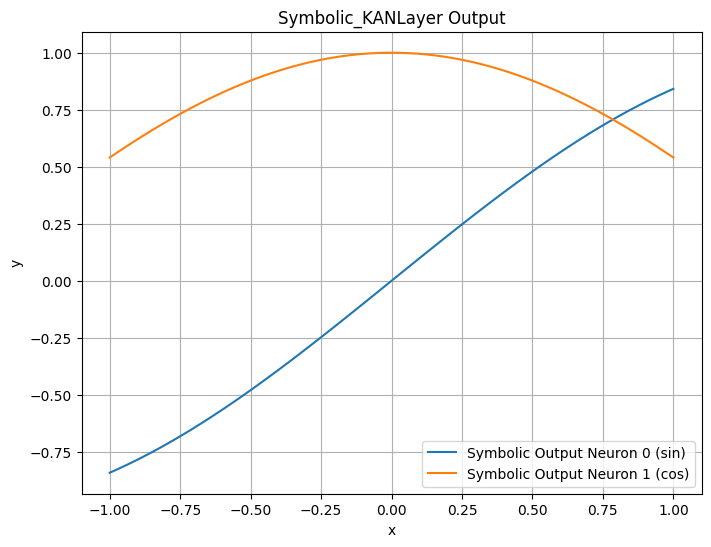

In [17]:
# Symbolic_KANLayer 사용 예제
import torch
import matplotlib.pyplot as plt

# 입력 데이터 생성
batch_size = 100
in_dim = 2
out_dim = 2
x = torch.linspace(-1, 1, steps=batch_size).unsqueeze(1).repeat(1, in_dim)  # (batch_size=100, in_dim=2)

# Symbolic_KANLayer 초기화
symbolic_layer = Symbolic_KANLayer(in_dim=in_dim, out_dim=out_dim, device='cpu')

# 기호적 함수 할당
# 레이어 0의 뉴런 0에 'sin', 뉴런 1에 'cos' 함수 할당
symbolic_layer.fix_symbolic(i=0, j=0, fun_name='sin')
symbolic_layer.fix_symbolic(i=1, j=1, fun_name='cos')

# 순전파 실행
y_symbolic, postacts_symbolic = symbolic_layer(x)

# 시각화
plt.figure(figsize=(8, 6))
plt.plot(x[:, 0].numpy(), y_symbolic[:, 0].detach().numpy(), label='Symbolic Output Neuron 0 (sin)')
plt.plot(x[:, 1].numpy(), y_symbolic[:, 1].detach().numpy(), label='Symbolic Output Neuron 1 (cos)')
plt.title('Symbolic_KANLayer Output')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


### 6. KAN Class

In [18]:

class KAN(nn.Module):
    def __init__(self, width, grid=5, k=3, base_fun='silu',
                 symbolic_enabled=True, affine_trainable=True,  # affine_trainable=True로 변경
                 device='cpu'):
        super(KAN, self).__init__()
        self.device = device
        self.depth = len(width) - 1
        self.width = width
        self.symbolic_enabled = symbolic_enabled

        self.act_fun = nn.ModuleList()
        self.symbolic_fun = nn.ModuleList()
        for l in range(self.depth):
            kan_layer = KANLayer(
                in_dim=width[l],
                out_dim=width[l + 1],
                num=grid,
                k=k,
                base_fun=torch.nn.SiLU(),
                device=device
            )
            self.act_fun.append(kan_layer)

            symbolic_layer = Symbolic_KANLayer(
                in_dim=width[l],
                out_dim=width[l + 1],
                device=device
            )
            self.symbolic_fun.append(symbolic_layer)

        self.node_bias = nn.ParameterList()
        self.node_scale = nn.ParameterList()
        self.subnode_bias = nn.ParameterList()
        self.subnode_scale = nn.ParameterList()
        for l in range(self.depth):
            self.node_bias.append(nn.Parameter(torch.zeros(width[l + 1], device=device), requires_grad=affine_trainable))
            self.node_scale.append(nn.Parameter(torch.ones(width[l + 1], device=device), requires_grad=affine_trainable))
            self.subnode_bias.append(nn.Parameter(torch.zeros(width[l + 1], device=device), requires_grad=affine_trainable))
            self.subnode_scale.append(nn.Parameter(torch.ones(width[l + 1], device=device), requires_grad=affine_trainable))

        self.to(device)

    def forward(self, x):
        for l in range(self.depth):
            x_numerical, preacts, postacts_numerical, postspline = self.act_fun[l](x)
            if self.symbolic_enabled:
                x_symbolic, postacts_symbolic = self.symbolic_fun[l](x)
            else:
                x_symbolic = torch.zeros_like(x_numerical)

            x = x_numerical + x_symbolic

            x = self.subnode_scale[l] * x + self.subnode_bias[l]
            x = self.node_scale[l] * x + self.node_bias[l]
        return x

    def symbolic_formula(self):
        formulas = []
        variables = [f"x{i}" for i in range(self.width[0])]
        for l in range(self.depth):
            layer_formulas = []
            for j in range(self.width[l + 1]):
                formula = ""
                for i in range(self.width[l]):
                    if self.symbolic_fun[l].mask.data[j, i] > 0 and self.symbolic_fun[l].funs[j][i] is not None:
                        a, b, c, d = self.symbolic_fun[l].affine.data[j, i]
                        func_name = self.symbolic_fun[l].funs_name[j][i]
                        var = variables[i]
                        term = f"{c.item():.3f} * {func_name}({a.item():.3f} * {var} + {b.item():.3f}) + "
                        formula += term
                formula = formula.rstrip(" + ")
                if formula == "":
                    formula = "0"
                layer_formulas.append(formula)
            variables = [f"h{l+1}_{j}" for j in range(self.width[l + 1])]
            formulas.append(layer_formulas)
        return formulas

    def fit(self, dataset, optimizer='Adam', steps=100, lr=0.001, lamb=0.0):
        '''
        KAN 모델을 학습합니다.

        Args:
        -----
            dataset : dict
                'train_input' 및 'train_label'을 포함하는 딕셔너리.
            optimizer : str
                사용할 옵티마이저 ('Adam' 또는 'LBFGS').
            steps : int
                학습 단계 수.
            lr : float
                학습률.
            lamb : float
                정규화 파라미터.

        Returns:
        --------
            None
        '''
        loss_fn = nn.MSELoss()

        if optimizer == 'Adam':
            optim = torch.optim.Adam(self.parameters(), lr=lr)
        elif optimizer == 'LBFGS':
            optim = torch.optim.LBFGS(self.parameters(), lr=lr)
        else:
            raise ValueError("Optimizer not recognized.")

        x_train = dataset['train_input']
        y_train = dataset['train_label']

        for step in range(steps):
            def closure():
                optim.zero_grad()
                output = self.forward(x_train)
                loss = loss_fn(output, y_train)
                # 필요 시 정규화 추가
                loss.backward()
                return loss

            if optimizer == 'LBFGS':
                optim.step(closure)
            else:
                loss = closure()
                optim.step()

            if step % 10 == 0:
                print(f"Step {step}: Loss = {loss.item()}")

    def prune(self, threshold=0.01):
        '''
        모델의 복잡도를 줄이기 위해 작은 계수를 가지는 연결을 제거합니다.

        Args:
        -----
            threshold : float
                가지치기 임계값. 이 값 이하의 절대값을 가진 계수는 제거됩니다.

        Returns:
        --------
            None
        '''
        for l in range(self.depth):
            # 수치적 층에서 작은 계수를 가지는 연결 제거
            small_sp = self.act_fun[l].scale_sp.abs() < threshold
            self.act_fun[l].mask.data[small_sp] = 0.0

            # 기호적 층에서 작은 계수를 가지는 연결 제거 (c 파라미터 기준)
            small_c = self.symbolic_fun[l].affine[:, :, 2].abs() < threshold
            self.symbolic_fun[l].mask.data[small_c] = 0.0

    def assign_symbolic_functions(self, assignments):
        '''
        여러 뉴런에 기호적 함수를 일괄 할당합니다.

        Args:
        -----
            assignments : list of tuples
                각 튜플은 (layer_index, output_neuron, input_neuron, function_name)
        '''
        for assignment in assignments:
            l, j, i, func_name = assignment
            if l < self.depth:
                self.symbolic_fun[l].fix_symbolic(j, i, func_name)
            else:
                print(f"Layer index {l} is out of range.")


In [19]:
# KAN 모델 사용 예시

# 네트워크 아키텍처 정의
width = [3, 5, 2]  # 입력 차원 3, 은닉층 5개 뉴런, 출력 차원 2

# KAN 모델 초기화
model = KAN(width=width, grid=5, k=3, device='cpu')

# 입력 데이터 생성
x = torch.randn(10, 3)

# 순전파 실행
output = model(x)

print("KAN 모델 출력:")
print(output)


KAN 모델 출력:
tensor([[-0.0363, -0.0278],
        [-0.1434, -0.0831],
        [-0.0991,  0.0203],
        [ 0.0316,  0.1476],
        [ 0.0464,  0.1095],
        [-0.0405,  0.0629],
        [ 0.0125,  0.0248],
        [ 0.0210,  0.0505],
        [-0.0119,  0.0244],
        [ 0.0343,  0.0840]], grad_fn=<AddBackward0>)


In [20]:
# KAN 모델 사용 예제
import torch
import matplotlib.pyplot as plt

# 네트워크 아키텍처 정의
width = [2, 5, 1]  # 입력 차원 2, 은닉층 5개 뉴런, 출력 차원 1

# KAN 모델 초기화
model = KAN(width=width, grid=5, k=3, device='cpu')

# 레이어 0의 모든 뉴런에 기호적 함수 할당
for i in range(model.width[0]):  # 입력 뉴런 인덱스
    for j in range(model.width[1]):  # 출력 뉴런 인덱스
        # 첫 번째 입력 x0에 대해 'sin', 두 번째 입력 x1에 대해 'cos' 함수 할당
        if i == 0:
            model.symbolic_fun[0].fix_symbolic(i, j, 'sin')
        elif i == 1:
            model.symbolic_fun[0].fix_symbolic(i, j, 'cos')

# 데이터셋 생성
batch_size = 100
x_train = torch.rand(batch_size, 2) * 2 - 1  # [-1, 1] 범위의 입력
y_train = torch.sin(x_train[:, 0]) + torch.cos(x_train[:, 1])  # (batch_size,)
y_train = y_train.unsqueeze(1)  # (batch_size, 1)

dataset = {
    'train_input': x_train,
    'train_label': y_train
}

# 모델 학습
model.fit(dataset, optimizer='Adam', steps=100, lr=0.01)


Assigned function 'sin' to Layer, Neuron 0, Input 0
Assigned function 'sin' to Layer, Neuron 0, Input 1


IndexError: list assignment index out of range

In [13]:
# 모델 학습 예제
import torch

# 네트워크 아키텍처 정의
width = [2, 5, 1]

# KAN 모델 초기화
model = KAN(width=width, grid=5, k=3, device='cpu')

# 데이터셋 생성
x_train = torch.rand(100, 2)
y_train = torch.sin(x_train[:, 0]) + x_train[:, 1] ** 2
y_train = y_train.unsqueeze(1)

dataset = {
    'train_input': x_train,
    'train_label': y_train
}

# 모델 학습
model.fit(dataset, optimizer='Adam', steps=100, lr=0.01)

# 테스트 데이터 생성
x_test = torch.rand(20, 2)
y_test = torch.sin(x_test[:, 0]) + x_test[:, 1] ** 2
y_test = y_test.unsqueeze(1)

# 예측 및 손실 계산
y_pred = model(x_test)
test_loss = nn.MSELoss()(y_pred, y_test)
print(f"Test Loss: {test_loss.item()}")


Step 0: Loss = 0.6423020362854004
Step 10: Loss = 0.1253228336572647
Step 20: Loss = 0.08409864455461502
Step 30: Loss = 0.014542357996106148
Step 40: Loss = 0.010408625937998295
Step 50: Loss = 0.0030659902840852737
Step 60: Loss = 0.0021975263953208923
Step 70: Loss = 0.0007675166707485914
Step 80: Loss = 0.00045903402497060597
Step 90: Loss = 0.0002122166333720088
Test Loss: 6.386656605172902e-05


=== 1. Verifying B-spline Basis Functions ===


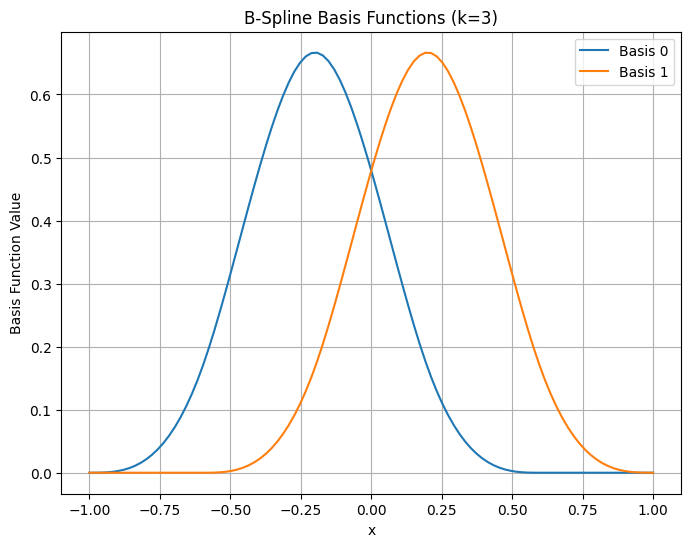

=== 2. Verifying Coefficient-Curve Transformation ===


ValueError: x and y can be no greater than 2D, but have shapes (100,) and (100, 1, 2)

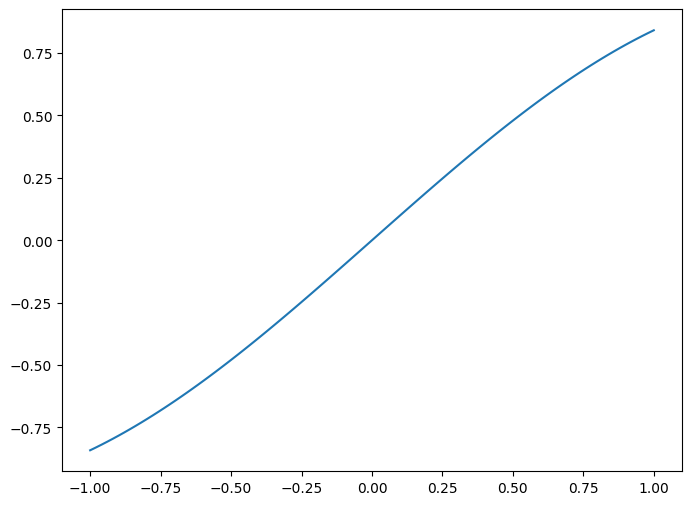

In [1]:
import torch
import torch.nn as nn
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# -------------------------------
# 1. B-spline Basis Function
# -------------------------------

def B_batch(x, grid, k=0, device='cpu'):
    """
    Evaluates B-spline basis functions at given points x.

    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, in_dim).
        grid (torch.Tensor): Knot vector of shape (in_dim, num_knots).
        k (int): Degree of the B-spline.
        device (str): Device to perform computations on.

    Returns:
        torch.Tensor: Evaluated B-spline basis functions of shape (batch_size, in_dim, num_basis).
    """
    x = x.unsqueeze(dim=2)  # (batch_size, in_dim, 1)
    grid = grid.unsqueeze(dim=0)  # (1, in_dim, num_knots)

    if k == 0:
        # 0-degree B-spline (step function)
        value = ((x >= grid[:, :, :-1]) & (x < grid[:, :, 1:])).float()
    else:
        # Recursive definition for higher-degree B-splines
        B_km1 = B_batch(x[:, :, 0], grid[0], k=k - 1, device=device)  # (batch_size, in_dim, num_basis_prev)
        denom1 = grid[:, :, k:-1] - grid[:, :, :-(k + 1)]  # (1, in_dim, num_knots - k -1)
        denom2 = grid[:, :, k + 1:] - grid[:, :, 1:(-k)]  # (1, in_dim, num_knots - k -1)
        denom1 = denom1.clamp(min=1e-8)  # Prevent division by zero
        denom2 = denom2.clamp(min=1e-8)
        term1 = ((x - grid[:, :, :-(k + 1)]) / denom1) * B_km1[:, :, :-1]
        term2 = ((grid[:, :, k + 1:] - x) / denom2) * B_km1[:, :, 1:]
        value = term1 + term2

    value = torch.nan_to_num(value)  # Replace NaNs with zero
    return value

# -------------------------------
# 2. Coefficient-Curve Transformation
# -------------------------------

def coef2curve(x_eval, grid, coef, k, device='cpu'):
    """
    Evaluates the B-spline curve at points x_eval using coefficients.

    Args:
        x_eval (torch.Tensor): Evaluation points of shape (batch_size, in_dim).
        grid (torch.Tensor): Knot vector of shape (in_dim, num_knots).
        coef (torch.Tensor): Coefficients of shape (in_dim, out_dim, num_basis).
        k (int): Degree of the B-spline.
        device (str): Device to perform computations on.

    Returns:
        torch.Tensor: Evaluated B-spline curve of shape (batch_size, in_dim, out_dim).
    """
    b_splines = B_batch(x_eval, grid, k=k, device=device)  # (batch_size, in_dim, num_basis)
    y_eval = torch.einsum('bik, iok -> bok', b_splines, coef)  # (batch_size, in_dim, out_dim)
    return y_eval

def curve2coef(x_eval, y_eval, grid, k, lamb=1e-8):
    """
    Computes B-spline coefficients from evaluated curves.

    Args:
        x_eval (torch.Tensor): Input points of shape (batch_size, in_dim).
        y_eval (torch.Tensor): Evaluated curves of shape (batch_size, in_dim, out_dim).
        grid (torch.Tensor): Knot vector of shape (in_dim, num_knots).
        k (int): Degree of the B-spline.
        lamb (float): Regularization parameter.

    Returns:
        torch.Tensor: Computed coefficients of shape (in_dim, out_dim, num_basis).
    """
    in_dim = x_eval.shape[1]
    out_dim = y_eval.shape[2]
    num_basis = grid.shape[1] - k - 1

    # Evaluate B-spline basis functions
    mat = B_batch(x_eval, grid, k=k, device=x_eval.device)  # (batch_size, in_dim, num_basis)
    mat = mat.permute(1, 0, 2).reshape(in_dim * x_eval.shape[0], -1)  # (in_dim * batch_size, num_basis)

    y_eval = y_eval.permute(1, 0, 2).reshape(in_dim * y_eval.shape[0], -1)  # (in_dim * batch_size, out_dim)

    # Least squares with regularization
    XtX = mat.T @ mat  # (num_basis, num_basis)
    XtX += lamb * torch.eye(num_basis, device=mat.device)  # Regularization
    XtY = mat.T @ y_eval  # (num_basis, out_dim)

    coef = torch.linalg.solve(XtX, XtY)  # (num_basis, out_dim)
    coef = coef.T.reshape(in_dim, out_dim, num_basis)  # (in_dim, out_dim, num_basis)

    return coef

# -------------------------------
# 3. Grid Extension Function
# -------------------------------

def extend_grid(grid, k_extend=0):
    """
    Extends the knot grid to handle boundary conditions.

    Args:
        grid (torch.Tensor): Original knot vector of shape (in_dim, num_knots).
        k_extend (int): Number of knots to extend on each boundary.

    Returns:
        torch.Tensor: Extended knot vector.
    """
    h = (grid[:, -1:] - grid[:, :1]) / (grid.shape[1] - 1)  # Calculate spacing
    for _ in range(k_extend):
        grid = torch.cat([grid[:, :1] - h, grid, grid[:, -1:] + h], dim=1)
    return grid

# -------------------------------
# 4. KANLayer Class
# -------------------------------

class KANLayer(nn.Module):
    """
    KANLayer class implementing a single layer of the KAN network.
    """

    def __init__(self, in_dim=3, out_dim=2, num=5, k=3, noise_scale=0.1,
                 scale_base_mu=0.0, scale_base_sigma=1.0, scale_sp=1.0,
                 base_fun=torch.nn.SiLU(), grid_eps=0.02, grid_range=[-1, 1],
                 sp_trainable=True, sb_trainable=True, device='cpu', sparse_init=False):
        """
        Initializes the KANLayer.

        Args:
            in_dim (int): Input dimension.
            out_dim (int): Output dimension.
            num (int): Number of grid intervals.
            k (int): Degree of the B-spline.
            noise_scale (float): Scale of initial noise.
            scale_base_mu (float): Mean of the base scaling factor.
            scale_base_sigma (float): Std dev of the base scaling factor.
            scale_sp (float): Scaling factor for the spline.
            base_fun (callable): Base activation function.
            grid_eps (float): Grid adaptation parameter.
            grid_range (list): Range of the grid.
            sp_trainable (bool): Whether spline scaling is trainable.
            sb_trainable (bool): Whether base scaling is trainable.
            device (str): Device to perform computations on.
            sparse_init (bool): Whether to initialize sparsely.
        """
        super(KANLayer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num = num
        self.k = k
        self.grid_eps = grid_eps
        self.device = device

        # Initialize grid
        grid = torch.linspace(grid_range[0], grid_range[1], steps=num + 1).unsqueeze(0).repeat(in_dim, 1)
        grid = extend_grid(grid, k_extend=k)
        self.grid = nn.Parameter(grid, requires_grad=False)  # (in_dim, num_knots)

        num_knots = num + 1 + 2 * k
        num_basis = num + k  # Number of B-spline bases

        x_eval = self.grid[:, k:-k].t()  # (num +1, in_dim)

        # Initialize coefficients with noise
        noises = (torch.rand(num + 1, in_dim, out_dim) - 0.5) * noise_scale / num
        self.coef = nn.Parameter(curve2coef(x_eval, noises, self.grid, k), requires_grad=True)  # (in_dim, out_dim, num_basis)

        # Initialize scaling factors
        self.scale_base = nn.Parameter(
            scale_base_mu / np.sqrt(in_dim) +
            scale_base_sigma * (torch.rand(in_dim, out_dim) * 2 - 1) / np.sqrt(in_dim),
            requires_grad=sb_trainable
        )
        self.scale_sp = nn.Parameter(torch.ones(in_dim, out_dim) * scale_sp, requires_grad=sp_trainable)

        self.base_fun = base_fun

        # Initialize mask
        if sparse_init:
            self.mask = nn.Parameter(torch.randint(0, 2, (in_dim, out_dim)).float(), requires_grad=False)
        else:
            self.mask = nn.Parameter(torch.ones(in_dim, out_dim), requires_grad=False)

        self.to(device)

    def forward(self, x):
        """
        Forward pass of KANLayer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_dim).

        Returns:
            tuple: Output y, preacts, postacts, postspline
        """
        batch_size = x.shape[0]
        preacts = x.unsqueeze(1).expand(batch_size, self.out_dim, self.in_dim)  # (batch_size, out_dim, in_dim)
        base = self.base_fun(x)  # (batch_size, in_dim)
        y_spline = coef2curve(x, self.grid, self.coef, self.k, device=self.device)  # (batch_size, in_dim, out_dim)
        postspline = y_spline.permute(0, 2, 1)  # (batch_size, out_dim, in_dim)
        y = self.scale_base.unsqueeze(0) * base.unsqueeze(2) + self.scale_sp.unsqueeze(0) * y_spline  # (batch_size, in_dim, out_dim)
        y = self.mask.unsqueeze(0) * y  # Apply mask
        postacts = y.permute(0, 2, 1)  # (batch_size, out_dim, in_dim)
        y = y.sum(dim=1)  # (batch_size, out_dim)
        return y, preacts, postacts, postspline

# -------------------------------
# 5. Symbolic_KANLayer Class
# -------------------------------

# Symbolic function library
SYMBOLIC_LIB = {
    'sin': (torch.sin, sp.sin, 'sin', lambda x, y_th: ((), torch.sin(x))),
    'cos': (torch.cos, sp.cos, 'cos', lambda x, y_th: ((), torch.cos(x))),
    'exp': (torch.exp, sp.exp, 'exp', lambda x, y_th: ((), torch.exp(x))),
    # Add more functions as needed
}

class Symbolic_KANLayer(nn.Module):
    """
    Symbolic_KANLayer class handling symbolic activation functions.
    """

    def __init__(self, in_dim=3, out_dim=2, device='cpu'):
        """
        Initializes the Symbolic_KANLayer.

        Args:
            in_dim (int): Input dimension.
            out_dim (int): Output dimension.
            device (str): Device to perform computations on.
        """
        super(Symbolic_KANLayer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.device = device

        # Initialize masks and function lists
        self.mask = nn.Parameter(torch.zeros(out_dim, in_dim, device=device), requires_grad=False)
        self.funs = [[lambda x: x * 0 for _ in range(in_dim)] for _ in range(out_dim)]
        self.funs_avoid_singularity = [[lambda x, y_th: ((), x * 0) for _ in range(in_dim)] for _ in range(out_dim)]
        self.funs_name = [['0' for _ in range(in_dim)] for _ in range(out_dim)]
        self.funs_sympy = [['0' for _ in range(in_dim)] for _ in range(out_dim)]
        # Affine parameters: [a, b, c, d] for c * f(a * x + b) + d
        self.affine = nn.Parameter(torch.randn(out_dim, in_dim, 4) * 0.1, requires_grad=True)
        self.to(device)

    def forward(self, x, singularity_avoiding=False, y_th=10.):
        """
        Forward pass of Symbolic_KANLayer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_dim).
            singularity_avoiding (bool): Whether to use singularity avoiding functions.
            y_th (float): Threshold for singularity avoidance.

        Returns:
            tuple: Output y, postacts
        """
        batch_size = x.shape[0]
        postacts = []

        for j in range(self.out_dim):
            postacts_j = []
            for i in range(self.in_dim):
                if self.mask[j, i] > 0:
                    a, b, c, d = self.affine[j, i]
                    input_transformed = a * x[:, i] + b
                    if singularity_avoiding:
                        _, f_val = self.funs_avoid_singularity[j][i](input_transformed, y_th)
                        xij = c * f_val + d
                    else:
                        f_val = self.funs[j][i](input_transformed)
                        xij = c * f_val + d
                    postacts_j.append(xij.unsqueeze(1))
                else:
                    postacts_j.append(torch.zeros(batch_size, 1, device=x.device))
            # Sum contributions from all inputs
            y_j = torch.cat(postacts_j, dim=1).sum(dim=1)  # (batch_size,)
            postacts.append(y_j.unsqueeze(1))  # (batch_size, 1)

        postacts = torch.cat(postacts, dim=1)  # (batch_size, out_dim)
        y = postacts
        return y, postacts

    def fix_symbolic(self, i, j, fun_name, a=None, b=None, c=None, d=None, verbose=True):
        """
        Assigns a symbolic function to a specific connection and sets affine parameters.

        Args:
            i (int): Input neuron index.
            j (int): Output neuron index.
            fun_name (str): Name of the symbolic function ('sin', 'cos', 'exp', etc.).
            a (float, optional): Affine parameter a. Randomly initialized if not provided.
            b (float, optional): Affine parameter b. Randomly initialized if not provided.
            c (float, optional): Affine parameter c. Randomly initialized if not provided.
            d (float, optional): Affine parameter d. Randomly initialized if not provided.
            verbose (bool): Whether to print assignment details.
        """
        if fun_name in SYMBOLIC_LIB:
            fun, fun_sympy, fun_str, fun_avoid_singularity = SYMBOLIC_LIB[fun_name]
            self.funs[j][i] = fun
            self.funs_sympy[j][i] = fun_sympy
            self.funs_name[j][i] = fun_str
            self.funs_avoid_singularity[j][i] = fun_avoid_singularity

            # Set affine parameters
            if a is None:
                a = torch.randn(1).item() * 1.0  # Scaling parameter a
            if b is None:
                b = torch.randn(1).item() * 0.0  # Shift parameter b
            if c is None:
                c = torch.randn(1).item() * 1.0  # Scaling parameter c
            if d is None:
                d = torch.randn(1).item() * 0.0  # Shift parameter d

            self.affine.data[j, i, 0] = a
            self.affine.data[j, i, 1] = b
            self.affine.data[j, i, 2] = c
            self.affine.data[j, i, 3] = d

            self.mask.data[j, i] = 1.0

            if verbose:
                print(f"Symbolic function '{fun_name}' assigned to Layer {j}, Connection {i} with affine params a={a:.3f}, b={b:.3f}, c={c:.3f}, d={d:.3f}")
        else:
            print(f"Symbolic function '{fun_name}' is not defined.")

# -------------------------------
# 6. KAN Class
# -------------------------------

class KAN(nn.Module):
    """
    Kolmogorov-Arnold Network (KAN) class.
    """

    def __init__(self, width, grid=5, k=3, base_fun='silu',
                 symbolic_enabled=True, affine_trainable=False,
                 device='cpu'):
        """
        Initializes the KAN model.

        Args:
            width (list): List specifying the number of neurons in each layer.
            grid (int): Number of grid intervals for B-spline.
            k (int): Degree of the B-spline.
            base_fun (str or callable): Base activation function ('silu' or custom).
            symbolic_enabled (bool): Whether to enable symbolic computations.
            affine_trainable (bool): Whether affine parameters are trainable.
            device (str): Device to perform computations on.
        """
        super(KAN, self).__init__()
        self.device = device
        self.depth = len(width) - 1
        self.width = width
        self.symbolic_enabled = symbolic_enabled

        self.act_fun = nn.ModuleList()
        self.symbolic_fun = nn.ModuleList()
        for l in range(self.depth):
            kan_layer = KANLayer(
                in_dim=width[l],
                out_dim=width[l + 1],
                num=grid,
                k=k,
                base_fun=torch.nn.SiLU() if base_fun == 'silu' else base_fun,
                device=device
            )
            self.act_fun.append(kan_layer)

            symbolic_layer = Symbolic_KANLayer(
                in_dim=width[l],
                out_dim=width[l + 1],
                device=device
            )
            self.symbolic_fun.append(symbolic_layer)

        self.node_bias = nn.ParameterList()
        self.node_scale = nn.ParameterList()
        self.subnode_bias = nn.ParameterList()
        self.subnode_scale = nn.ParameterList()
        for l in range(self.depth):
            self.node_bias.append(nn.Parameter(torch.zeros(width[l + 1], device=device), requires_grad=affine_trainable))
            self.node_scale.append(nn.Parameter(torch.ones(width[l + 1], device=device), requires_grad=affine_trainable))
            self.subnode_bias.append(nn.Parameter(torch.zeros(width[l + 1], device=device), requires_grad=affine_trainable))
            self.subnode_scale.append(nn.Parameter(torch.ones(width[l + 1], device=device), requires_grad=affine_trainable))

        self.to(device)

    def forward(self, x):
        """
        Forward pass of the KAN model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, width[0]).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, width[-1]).
        """
        for l in range(self.depth):
            x_numerical, preacts, postacts_numerical, postspline = self.act_fun[l](x)
            if self.symbolic_enabled:
                x_symbolic, postacts_symbolic = self.symbolic_fun[l](x)
            else:
                x_symbolic = torch.zeros_like(x_numerical)

            x = x_numerical + x_symbolic

            x = self.subnode_scale[l] * x + self.subnode_bias[l]
            x = self.node_scale[l] * x + self.node_bias[l]
        return x

    def symbolic_formula(self):
        """
        Extracts symbolic formulas from the trained model.

        Returns:
            list: List of symbolic formulas for each layer and neuron.
        """
        formulas = []
        variables = [f"x{i}" for i in range(self.width[0])]
        for l in range(self.depth):
            layer_formulas = []
            for j in range(self.width[l + 1]):
                formula = ""
                for i in range(self.width[l]):
                    if self.symbolic_fun[l].mask.data[j, i] > 0:
                        a, b, c, d = self.symbolic_fun[l].affine.data[j, i]
                        func_name = self.symbolic_fun[l].funs_name[j][i]
                        var = variables[i]
                        term = f"{c.item():.3f} * {func_name}({a.item():.3f} * {var} + {b.item():.3f}) + {d.item():.3f}"
                        formula += term + " + "
                formula = formula.rstrip(" + ")
                layer_formulas.append(formula if formula else "0")
            variables = [f"h{l}_{j}" for j in range(self.width[l + 1])]
            formulas.append(layer_formulas)
        return formulas

    def fit(self, dataset, optimizer='Adam', steps=100, lr=0.001, lamb=0.0):
        """
        Trains the KAN model.

        Args:
            dataset (dict): Dictionary containing 'train_input' and 'train_label'.
            optimizer (str): Optimizer to use ('Adam' or 'LBFGS').
            steps (int): Number of training steps.
            lr (float): Learning rate.
            lamb (float): Regularization parameter.

        Returns:
            list: List of loss values at each step.
        """
        loss_fn = nn.MSELoss()

        if optimizer == 'Adam':
            optim = torch.optim.Adam(self.parameters(), lr=lr)
        elif optimizer == 'LBFGS':
            optim = torch.optim.LBFGS(self.parameters(), lr=lr)
        else:
            raise ValueError("Optimizer not recognized.")

        x_train = dataset['train_input']
        y_train = dataset['train_label']

        loss_history = []

        for step in range(steps):
            def closure():
                optim.zero_grad()
                output = self.forward(x_train)
                loss = loss_fn(output, y_train)
                loss.backward()
                return loss

            if optimizer == 'LBFGS':
                loss = optim.step(closure)
            else:
                loss = closure()
                optim.step()

            loss_value = loss.item()
            loss_history.append(loss_value)

            if step % 10 == 0:
                print(f"Step {step}: Loss = {loss_value:.4f}")

        return loss_history

    def prune(self, threshold=0.01):
        """
        Prunes connections with weights below the threshold.

        Args:
            threshold (float): Threshold below which connections are pruned.

        Returns:
            None
        """
        for l in range(self.depth):
            # Prune numerical layer based on scale_sp
            mask = self.act_fun[l].scale_sp.abs() > threshold
            self.act_fun[l].mask.data = self.act_fun[l].mask.data * mask.float()

            # Prune symbolic layer based on affine's c parameter
            mask_symbolic = self.symbolic_fun[l].affine.data[:, :, 2].abs() > threshold
            self.symbolic_fun[l].mask.data = self.symbolic_fun[l].mask.data * mask_symbolic.float()

# -------------------------------
# 7. Example Usage and Visualization
# -------------------------------

def main():
    # -------------------------------
    # 7.1. B-spline Basis Function Verification
    # -------------------------------
    print("=== 1. Verifying B-spline Basis Functions ===")
    # Input data
    x = torch.linspace(-1, 1, steps=100).unsqueeze(1)  # (batch_size=100, in_dim=1)

    # Knot vector
    num_knots = 6
    grid = torch.linspace(-1, 1, steps=num_knots).unsqueeze(0)  # (in_dim=1, num_knots=6)

    # Degree
    k = 3  # 3rd degree B-spline

    # Evaluate B-spline basis functions
    B_values = B_batch(x, grid, k=k, device='cpu')  # (batch_size=100, in_dim=1, num_basis=3)

    # Plot B-spline basis functions
    plt.figure(figsize=(8, 6))
    for i in range(B_values.shape[2]):
        plt.plot(x.squeeze().numpy(), B_values[:, 0, i].detach().numpy(), label=f'Basis {i}')
    plt.title('B-Spline Basis Functions (k=3)')
    plt.xlabel('x')
    plt.ylabel('Basis Function Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # -------------------------------
    # 7.2. Coefficient-Curve Transformation Verification
    # -------------------------------
    print("=== 2. Verifying Coefficient-Curve Transformation ===")
    # Input points
    x_eval = torch.linspace(-1, 1, steps=100).unsqueeze(1)  # (batch_size=100, in_dim=1)
    y_true = torch.sin(x_eval)  # (batch_size=100, in_dim=1)

    # Knot vector
    grid = torch.linspace(-1, 1, steps=num_knots).unsqueeze(0)  # (in_dim=1, num_knots=6)

    # Degree
    k = 3

    # Initialize coefficients
    coef = torch.tensor([[[1.0, 0.5]]], dtype=torch.float32)  # (in_dim=1, out_dim=1, num_basis=2)

    # Generate spline curve
    y_pred = coef2curve(x_eval, grid, coef, k=k, device='cpu')  # (batch_size=100, in_dim=1, out_dim=1)
    y_pred = y_pred.squeeze(2)  # (batch_size=100, in_dim=1)

    # Plot true curve and spline curve
    plt.figure(figsize=(8, 6))
    plt.plot(x_eval.squeeze(1).numpy(), y_true.numpy(), label='True Curve')
    plt.plot(x_eval.squeeze(1).numpy(), y_pred.detach().numpy(), label='Spline Curve')
    plt.title('Curve Fitting with B-Spline')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

    # -------------------------------
    # 7.3. Grid Extension Verification
    # -------------------------------
    print("=== 3. Verifying Grid Extension ===")
    # Original grid
    original_grid = torch.linspace(0, 1, steps=num_knots).unsqueeze(0)  # (in_dim=1, num_knots=6)

    # Extend grid
    k_extend = 2
    extended_grid = extend_grid(original_grid, k_extend=k_extend)  # (1, 10)

    # Plot original and extended grid
    plt.figure(figsize=(10, 2))
    plt.stem(range(extended_grid.shape[1]), extended_grid.squeeze().numpy(), use_line_collection=True)
    plt.title(f'Grid Expansion with k_extend={k_extend}')
    plt.xlabel('Knot Index')
    plt.ylabel('Grid Value')
    plt.show()

    # -------------------------------
    # 7.4. KANLayer Verification
    # -------------------------------
    print("=== 4. Verifying KANLayer ===")
    # Input data
    batch_size = 100
    in_dim = 1
    out_dim = 1
    x_kan = torch.linspace(-1, 1, steps=batch_size).unsqueeze(1)  # (batch_size=100, in_dim=1)

    # Initialize KANLayer
    kan_layer = KANLayer(in_dim=in_dim, out_dim=out_dim, num=5, k=3, device='cpu')

    # Set coefficients manually for testing
    with torch.no_grad():
        kan_layer.coef.copy_(torch.tensor([[[1.0, 0.5]]], dtype=torch.float32))  # (in_dim=1, out_dim=1, num_basis=2)

    # Forward pass
    y_kan, preacts, postacts, postspline = kan_layer(x_kan)

    # Plot KANLayer output and post-activation
    plt.figure(figsize=(8, 6))
    plt.plot(x_kan.numpy(), y_kan.numpy(), label='KANLayer Output')
    plt.plot(x_kan.numpy(), postacts.squeeze().numpy(), label='Post-Activation')
    plt.title('KANLayer Output and Post-Activation')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

    # -------------------------------
    # 7.5. Symbolic_KANLayer Verification
    # -------------------------------
    print("=== 5. Verifying Symbolic_KANLayer ===")
    # Input data
    batch_size = 100
    in_dim = 2
    out_dim = 2
    x_symbolic = torch.linspace(-1, 1, steps=batch_size).unsqueeze(1).repeat(1, in_dim)  # (batch_size=100, in_dim=2)

    # Initialize Symbolic_KANLayer
    symbolic_layer = Symbolic_KANLayer(in_dim=in_dim, out_dim=out_dim, device='cpu')

    # Assign symbolic functions
    symbolic_layer.fix_symbolic(i=0, j=0, fun_name='sin')
    symbolic_layer.fix_symbolic(i=1, j=1, fun_name='cos')

    # Forward pass
    y_symbolic, postacts_symbolic = symbolic_layer(x_symbolic)

    # Plot Symbolic_KANLayer outputs
    plt.figure(figsize=(8, 6))
    plt.plot(x_symbolic[:, 0].numpy(), y_symbolic[:, 0].detach().numpy(), label='Symbolic Output Neuron 0 (sin)')
    plt.plot(x_symbolic[:, 1].numpy(), y_symbolic[:, 1].detach().numpy(), label='Symbolic Output Neuron 1 (cos)')
    plt.title('Symbolic_KANLayer Output')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

    # -------------------------------
    # 7.6. Full KAN Model Training and Visualization
    # -------------------------------
    print("=== 6. Training Full KAN Model ===")
    # Define network architecture
    width = [2, 5, 1]  # Input dim=2, hidden layer with 5 neurons, output dim=1

    # Initialize KAN model
    model = KAN(width=width, grid=5, k=3, device='cpu')

    # Assign symbolic functions to first layer
    for i in range(model.width[0]):  # Input neurons
        for j in range(model.width[1]):  # Hidden neurons
            if i == 0:
                model.symbolic_fun[0].fix_symbolic(i, j, 'sin')
            elif i == 1:
                model.symbolic_fun[0].fix_symbolic(i, j, 'cos')

    # Create dataset
    batch_size = 1000
    x_train = torch.rand(batch_size, 2) * 2 - 1  # Inputs in range [-1, 1]
    y_train = torch.sin(x_train[:, 0]) + torch.cos(x_train[:, 1])  # Target: sin(x0) + cos(x1)
    y_train = y_train.unsqueeze(1)  # (batch_size, 1)

    dataset = {
        'train_input': x_train,
        'train_label': y_train
    }

    # Train the model and record loss
    loss_history = model.fit(dataset, optimizer='Adam', steps=100, lr=0.01)

    # Plot training loss
    plt.figure(figsize=(8, 6))
    plt.plot(loss_history, label='Training Loss')
    plt.title('KAN Model Training Loss')
    plt.xlabel('Step')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # -------------------------------
    # 7.7. Pruning and Post-Pruning Evaluation
    # -------------------------------
    print("=== 7. Pruning the Model ===")
    # Prune the model
    pruning_threshold = 0.05
    model.prune(threshold=pruning_threshold)

    # Check masks after pruning
    print("Pruning completed.")

    # -------------------------------
    # 7.8. Extract and Visualize Symbolic Formulas
    # -------------------------------
    print("=== 8. Extracting Symbolic Formulas ===")
    # Extract symbolic formulas
    formulas = model.symbolic_formula()
    print("Extracted Symbolic Formulas:")
    for l, layer_formulas in enumerate(formulas):
        print(f"Layer {l}:")
        for idx, formula in enumerate(layer_formulas):
            print(f"  Neuron {idx}: {formula}")

    # Visualize symbolic formula of first layer, first neuron
    if len(formulas) > 0 and len(formulas[0]) > 0:
        layer = 0
        neuron = 0
        formula = formulas[layer][neuron]
        print(f"\nLayer {layer}, Neuron {neuron} Formula: {formula}")

        # Convert formula to SymPy expression
        expr = sp.sympify(formula)

        # Create a lambda function for evaluation
        f_np = sp.lambdify(('x0', 'x1'), expr, 'numpy')

        # Create meshgrid for visualization
        x0_vals = np.linspace(-1, 1, 100)
        x1_vals = np.linspace(-1, 1, 100)
        X0, X1 = np.meshgrid(x0_vals, x1_vals)
        Y = f_np(X0, X1)

        # Plot the symbolic function
        plt.figure(figsize=(8, 6))
        contour = plt.contourf(X0, X1, Y, levels=50, cmap='viridis')
        plt.colorbar(contour)
        plt.title(f'Layer {layer}, Neuron {neuron} Symbolic Function')
        plt.xlabel('x0')
        plt.ylabel('x1')
        plt.show()

    # -------------------------------
    # 7.9. Test Loss After Pruning
    # -------------------------------
    print("=== 9. Evaluating Test Loss After Pruning ===")
    # Create test dataset
    x_test = torch.rand(200, 2) * 2 - 1  # Inputs in range [-1, 1]
    y_test = torch.sin(x_test[:, 0]) + torch.cos(x_test[:, 1])  # Target: sin(x0) + cos(x1)
    y_test = y_test.unsqueeze(1)  # (batch_size, 1)

    # Predict using the trained model
    y_pred = model(x_test)

    # Compute test loss
    test_loss = nn.MSELoss()(y_pred, y_test)
    print(f"Test Loss after Pruning: {test_loss.item():.4f}")

    # -------------------------------
    # 7.10. Visualize Predictions vs True Values
    # -------------------------------
    print("=== 10. Visualizing Predictions ===")
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test.numpy(), y_pred.detach().numpy(), alpha=0.5)
    plt.plot([-2, 2], [-2, 2], 'r--')  # Diagonal line
    plt.title('Predictions vs True Values')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
